# Import all libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
import cv2
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

IMAGE_DIR = '/kaggle/input/smartphone-image-denoising-dataset/SIDD_Small_sRGB_Only/Data/'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Helpers

In [2]:
IMAGE_SHAPE = (256, 256, 3)
def load_and_preprocess_images(img_path, img_shape=IMAGE_SHAPE):
    """
    Load the images from the path
    """
    img_path = cv2.imread(img_path)
    img_path = cv2.cvtColor(img_path, cv2.COLOR_BGR2RGB)
    img_path = cv2.resize(img_path, img_shape[:-1])
    return img_path

def tf_data_gen(features, labels, batch_size=8):
    """
    Load the data to tensorflow dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels)) 
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

def scale(x):
    return x.astype('float32')/255

def reverse_scale(x):
    return x.astype('float32')*255
def reshape(x, img_shape):
    return cv2.resize(x, img_shape)

def plot_training_history(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    
def predict_fn(im, model):
    """
    Return the image with noises removed
    """
    return tf.squeeze(model.predict(tf.expand_dims(im, axis=0)))

def make_prediction_plot(img, ground_truth, model):
    """
    Plot the Grounded thruth and Predicted and Original
    """
    fig, ax = plt.subplots(1, 3, figsize=(10,14))
    ax[0].imshow(img)
    ax[0].set_title('Noise')

    ax[1].imshow(ground_truth)
    ax[1].set_title('Thruth')

    prediction = predict_fn(img, model)
    print(prediction.shape)
    ax[2].imshow(prediction)
    ax[2].set_title('Predicted')
    plt.show()

def return_sample_from_batch(data_batch, len_batch=1):
    """
    Return len_batch from data_batch
    """
    for feature, label in data_batch.take(len_batch): # one batch
        sample_x = feature.numpy()
        sample_y = label.numpy()    
    return sample_x, sample_y

def evaluate(y_true, y_predict):
    """
    Evaluate the model using Mean Square error  and Mean Absolute error"""
    eval_matrix = {}
    mse = tf.reduce_mean(tf.square(y_predict - y_true))
    mae = tf.reduce_mean(tf.abs(y_predict - y_true))
    eval_matrix['mse'] =  np.array(mse)
    eval_matrix['mae'] =  np.array(mae)
    return eval_matrix
    

# Loading the data

## Super Resolutoin benchmarks Images Loading

In [3]:
image_resolution_path = '/kaggle/input/super-resolution-benchmarks/'
image_extention = ['png', 'jpg']
super_resolution_paths_images = []
for root, dirs, files in os.walk(image_resolution_path):
    for file in files:
        if file:
            super_resolution_paths_images.append(os.path.join(root, file))
super_resolution_paths_images = super_resolution_paths_images[2:]

In [4]:
def add_noise(image,mean=10,std_dev=100):
        #Transform the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Generate random noise
    noise = np.zeros(image_rgb.shape, np.uint8)
    cv2.randn(noise, mean, std_dev)

    # Add noise to the image
    noisy_image = cv2.add(image_rgb, noise)
    
    return noisy_image

In [5]:
len(super_resolution_paths_images)

1342

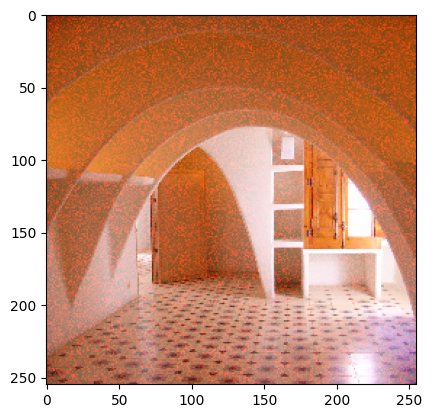

In [6]:
img = cv2.imread(super_resolution_paths_images[0])
plt.imshow(reshape(add_noise(img), (255, 255)))

In [7]:
# features
X_a = []
# noises
y_a = []

for sp_img in tqdm(super_resolution_paths_images):
    y_a.append(load_and_preprocess_images(sp_img))


for _a in tqdm(y_a):
    reshaped_img = reshape(add_noise(_a), IMAGE_SHAPE[:-1])
    X_a.append(cv2.cvtColor(reshaped_img, cv2.COLOR_BGR2RGB))

y_a = np.array(y_a)
X_a = np.array(X_a)
print("X_a shape: ",X_a.shape)
print("Y_a shape : ", y_a.shape)

  0%|          | 0/1342 [00:00<?, ?it/s]

  0%|          | 0/1342 [00:00<?, ?it/s]

X_a shape:  (1342, 256, 256, 3)
Y_a shape :  (1342, 256, 256, 3)


## SmartPhone Image Dataset Loading

In [8]:
all_folders = []
for i in os.listdir(IMAGE_DIR):
    all_folders.append(os.path.join(IMAGE_DIR,i))

all_images = []
noisy_imgs = []
cleaned_imgs = []
for folder in all_folders:
    for img in os.listdir(folder):
        if img == 'NOISY_SRGB_010.PNG':
            noisy_imgs.append(os.path.join(folder, img))
        else:
            cleaned_imgs.append(os.path.join(folder, img))

<Figure size 1000x500 with 0 Axes>

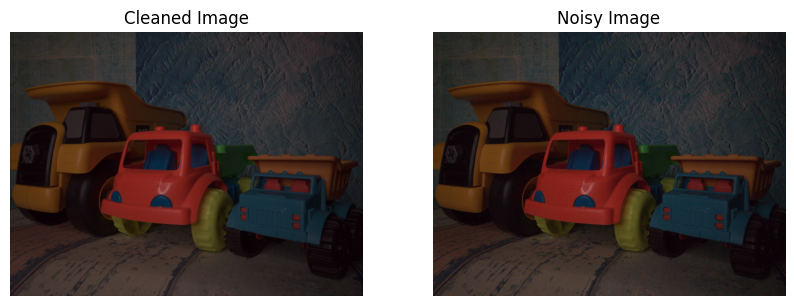

Noisy shape:  (3024, 4032, 3)
Cleaned shape:  (3024, 4032, 3)


In [9]:
# Get a random index from the list
random_index = random.randint(0, len(cleaned_imgs) - 1)
img_clean, img_noisy = cv2.imread(cleaned_imgs[random_index]), cv2.imread(noisy_imgs[random_index])
img_clean = cv2.cvtColor(img_clean, cv2.COLOR_BGR2RGB)

img_noisy =  cv2.cvtColor(img_noisy, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 5))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img_clean)
ax[0].axis('off')
ax[0].set_title('Cleaned Image')

ax[1].imshow(img_noisy)
ax[1].axis('off')
ax[1].set_title('Noisy Image')

plt.show()
print('Noisy shape: ', img_noisy.shape)
print('Cleaned shape: ', img_clean.shape)

In [10]:
# features
X_b = []
# noises
y_b = []
for ns_img in tqdm(noisy_imgs):
    X_b.append(load_and_preprocess_images(ns_img))
for cl_img in tqdm(cleaned_imgs):
    y_b.append(load_and_preprocess_images(cl_img))

X_b = np.array(X_b)
y_b = np.array(y_b)


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

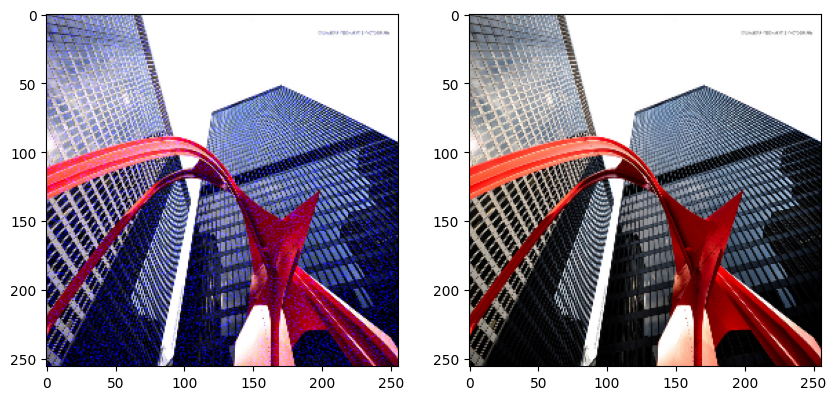

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(X_a[9])
ax[1].imshow(y_a[9])

In [12]:
print('X_a, y_a shape: ', X_a.shape, y_a.shape)
print('X_b, y_b shape: ', X_b.shape, y_b.shape)

X_a, y_a shape:  (1342, 256, 256, 3) (1342, 256, 256, 3)
X_b, y_b shape:  (160, 256, 256, 3) (160, 256, 256, 3)


## Merge the two dataset

In [13]:
X =  np.concatenate((X_a, X_b), axis=0)
y =  np.concatenate((y_a, y_b), axis=0)

X.shape, y.shape

((1502, 256, 256, 3), (1502, 256, 256, 3))

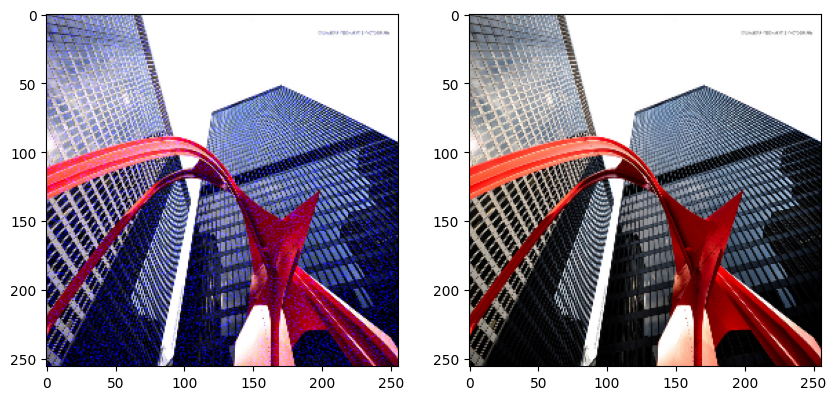

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(X[9])
ax[1].imshow(y[9])

## Split to train and test

In [15]:
split_size = len(X) * 0.8
print('Split size : ', split_size)

x_train, y_train = X[:int(split_size)], y[:int(split_size)]
x_test, y_test = X[int(split_size):], y[int(split_size):]
print('Train shape (x, y): ', x_train.shape, y_train.shape)
print('Test shape (x, y): ', x_test.shape, y_test.shape)

Split size :  1201.6000000000001
Train shape (x, y):  (1201, 256, 256, 3) (1201, 256, 256, 3)
Test shape (x, y):  (301, 256, 256, 3) (301, 256, 256, 3)


In [16]:
train_img_gen = tf_data_gen(scale(x_train), scale(y_train))
test_img_gen = tf_data_gen(scale(x_test), scale(y_test))

Batch shape : (8, 256, 256, 3) (8, 256, 256, 3)


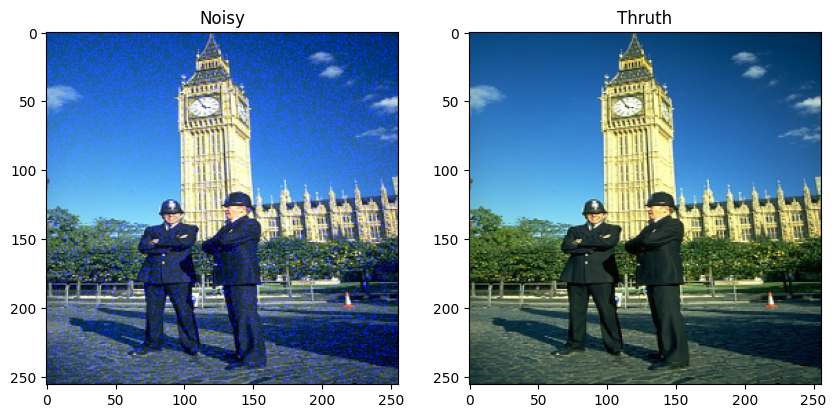

In [17]:
for feature, label in test_img_gen.take(1): # one batch
    sample_x = feature.numpy()
    sample_y = label.numpy()    

print("Batch shape :",sample_x.shape, sample_y.shape)
fig, ax = plt.subplots(1, 2, figsize=(10,14))
ax[0].imshow(sample_x[4])
ax[0].set_title('Noisy')

ax[1].imshow(sample_y[4])
ax[1].set_title('Thruth')
plt.show()

## Model 1: Basic model (Feed-Forward Neural Networks wih latent dim = 32)

In [18]:
def autoencoder(latent_dim=32, shape=IMAGE_SHAPE):
    input_layer = Input(shape=shape, name = 'Input layer')
    flatten = Flatten()(input_layer)
    encoded = Dense(latent_dim, activation='relu',name='Encoded_layer')(flatten)
    decoded = Dense(tf.math.reduce_prod(shape), activation='sigmoid', name='Decoded_layer')(encoded)
    shape_decoded = Reshape(shape)(decoded)
    model = Model(input_layer, shape_decoded)
    return model
    
model_1 = autoencoder()
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 Encoded_layer (Dense)       (None, 32)                6291488   
                                                                 
 Decoded_layer (Dense)       (None, 196608)            6488064   
                                                                 
 reshape (Reshape)           (None, 256, 256, 3)       0         
                                                                 
Total params: 12779552 (48.75 MB)
Trainable params: 12779552 (48.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
model_1.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [20]:
model_1_history = model_1.fit(train_img_gen, validation_data=test_img_gen, epochs=100, batch_size=8)

Epoch 1/100
151/151 [==============================] - 5s 13ms/step - loss: 0.0794 - val_loss: 0.0749
Epoch 2/100
151/151 [==============================] - 1s 9ms/step - loss: 0.0785 - val_loss: 0.0726
Epoch 3/100
151/151 [==============================] - 1s 9ms/step - loss: 0.0777 - val_loss: 0.0707
Epoch 4/100
151/151 [==============================] - 1s 9ms/step - loss: 0.0772 - val_loss: 0.0691
Epoch 5/100
151/151 [==============================] - 1s 9ms/step - loss: 0.0767 - val_loss: 0.0678
Epoch 6/100
151/151 [==============================] - 1s 9ms/step - loss: 0.0765 - val_loss: 0.0668
Epoch 7/100
151/151 [==============================] - 1s 9ms/step - loss: 0.0763 - val_loss: 0.0660
Epoch 8/100
151/151 [==============================] - 1s 9ms/step - loss: 0.0761 - val_loss: 0.0654
Epoch 9/100
151/151 [==============================] - 1s 9ms/step - loss: 0.0761 - val_loss: 0.0649
Epoch 10/100
151/151 [==============================] - 1s 9ms/step - loss: 0.0760 - val_l

151/151 [==============================] - 1s 9ms/step - loss: 0.0759 - val_loss: 0.0630
Epoch 82/100
151/151 [==============================] - 1s 9ms/step - loss: 0.0759 - val_loss: 0.0630
Epoch 83/100
151/151 [==============================] - 1s 9ms/step - loss: 0.0759 - val_loss: 0.0630
Epoch 84/100
151/151 [==============================] - 1s 9ms/step - loss: 0.0759 - val_loss: 0.0630
Epoch 85/100
151/151 [==============================] - 1s 9ms/step - loss: 0.0759 - val_loss: 0.0630
Epoch 86/100
151/151 [==============================] - 1s 9ms/step - loss: 0.0759 - val_loss: 0.0630
Epoch 87/100
151/151 [==============================] - 1s 9ms/step - loss: 0.0759 - val_loss: 0.0630
Epoch 88/100
151/151 [==============================] - 1s 9ms/step - loss: 0.0759 - val_loss: 0.0630
Epoch 89/100
151/151 [==============================] - 1s 9ms/step - loss: 0.0759 - val_loss: 0.0630
Epoch 90/100
151/151 [==============================] - 1s 9ms/step - loss: 0.0759 - val_loss: 

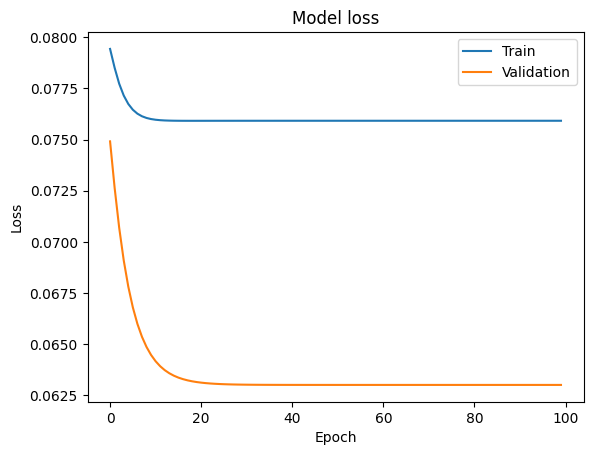

In [21]:
plot_training_history(model_1_history)

In [22]:
predict = model_1.evaluate(test_img_gen)
predict

38/38 [==============================] - 0s 7ms/step - loss: 0.0630


0.06300623714923859

In [23]:
model_1_matrix = evaluate(scale(y_test), model_1.predict(scale(x_test)))
model_1_matrix

10/10 [==============================] - 0s 10ms/step


{'mse': array(0.06300624, dtype=float32),
 'mae': array(0.21478158, dtype=float32)}

Batch shape : (8, 256, 256, 3) (8, 256, 256, 3)
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)


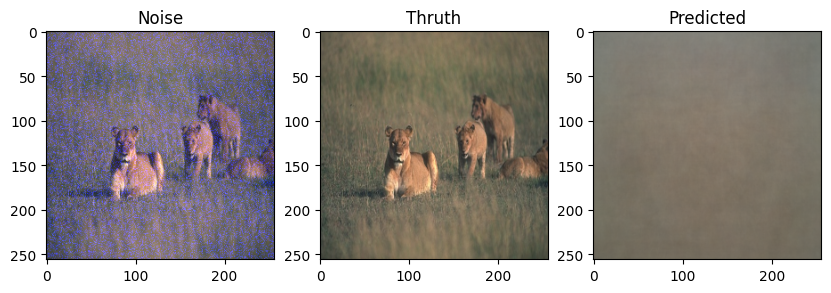

In [24]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[1], sample_y[1], model_1)

## Model 2: Basic model (Feed-Forward Neural Networks wih latent dim = 16)¶

In [25]:
model_2 = autoencoder(latent_dim=16) # Latent dim = 16
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 flatten_1 (Flatten)         (None, 196608)            0         
                                                                 
 Encoded_layer (Dense)       (None, 16)                3145744   
                                                                 
 Decoded_layer (Dense)       (None, 196608)            3342336   
                                                                 
 reshape_1 (Reshape)         (None, 256, 256, 3)       0         
                                                                 
Total params: 6488080 (24.75 MB)
Trainable params: 6488080 (24.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
model_2.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [27]:
model_2_history = model_2.fit(train_img_gen, validation_data=test_img_gen, epochs=100, shuffle=True)

Epoch 1/100
151/151 [==============================] - 2s 9ms/step - loss: 0.0794 - val_loss: 0.0749
Epoch 2/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0785 - val_loss: 0.0726
Epoch 3/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0777 - val_loss: 0.0707
Epoch 4/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0772 - val_loss: 0.0691
Epoch 5/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0767 - val_loss: 0.0678
Epoch 6/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0765 - val_loss: 0.0668
Epoch 7/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0763 - val_loss: 0.0660
Epoch 8/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0761 - val_loss: 0.0654
Epoch 9/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0761 - val_loss: 0.0649
Epoch 10/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0760 - val_lo

151/151 [==============================] - 1s 8ms/step - loss: 0.0759 - val_loss: 0.0630
Epoch 82/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0759 - val_loss: 0.0630
Epoch 83/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0759 - val_loss: 0.0630
Epoch 84/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0759 - val_loss: 0.0630
Epoch 85/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0759 - val_loss: 0.0630
Epoch 86/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0759 - val_loss: 0.0630
Epoch 87/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0759 - val_loss: 0.0630
Epoch 88/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0759 - val_loss: 0.0630
Epoch 89/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0759 - val_loss: 0.0630
Epoch 90/100
151/151 [==============================] - 1s 8ms/step - loss: 0.0759 - val_loss: 

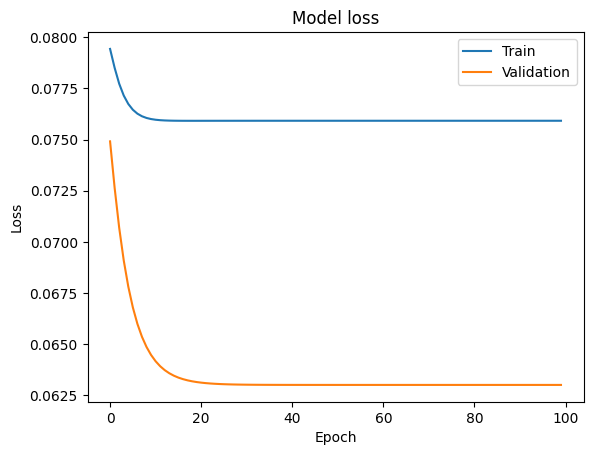

In [28]:
plot_training_history(model_2_history)

In [29]:
model_2_matrix = evaluate(scale(y_test), model_2.predict(scale(x_test)))
model_2_matrix

10/10 [==============================] - 0s 10ms/step


{'mse': array(0.06300624, dtype=float32),
 'mae': array(0.21478158, dtype=float32)}

Batch shape : (8, 256, 256, 3) (8, 256, 256, 3)
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)


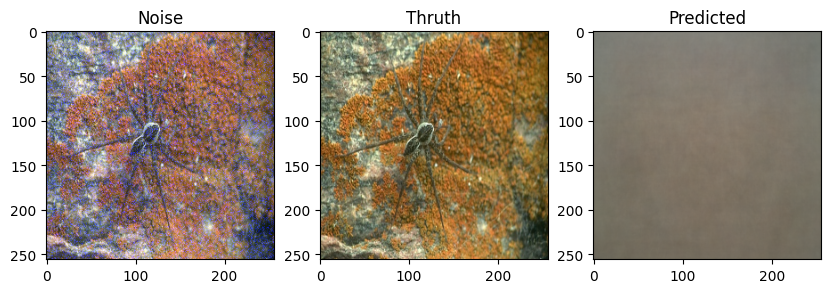

In [30]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[3], sample_y[3], model_2)

## Model 3:  More Dense layers

In [31]:
class Autoencoder(Model):
  def __init__(self, shape=IMAGE_SHAPE):
    super(Autoencoder, self).__init__()
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(32, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded



model_3 = Autoencoder()


In [32]:
model_3.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [33]:
model_3_history = model_3.fit(train_img_gen,
                epochs=100,
                shuffle=True,
                validation_data=test_img_gen)

Epoch 1/100
151/151 [==============================] - 5s 18ms/step - loss: 0.0761 - val_loss: 0.0704
Epoch 2/100
151/151 [==============================] - 2s 16ms/step - loss: 0.0742 - val_loss: 0.0683
Epoch 3/100
151/151 [==============================] - 2s 16ms/step - loss: 0.0731 - val_loss: 0.0635
Epoch 4/100
151/151 [==============================] - 2s 16ms/step - loss: 0.0727 - val_loss: 0.0621
Epoch 5/100
151/151 [==============================] - 3s 17ms/step - loss: 0.0720 - val_loss: 0.0602
Epoch 6/100
151/151 [==============================] - 2s 16ms/step - loss: 0.0717 - val_loss: 0.0588
Epoch 7/100
151/151 [==============================] - 2s 16ms/step - loss: 0.0706 - val_loss: 0.0500
Epoch 8/100
151/151 [==============================] - 2s 16ms/step - loss: 0.0677 - val_loss: 0.0463
Epoch 9/100
151/151 [==============================] - 2s 17ms/step - loss: 0.0666 - val_loss: 0.0412
Epoch 10/100
151/151 [==============================] - 2s 16ms/step - loss: 0.064

151/151 [==============================] - 2s 16ms/step - loss: 0.0582 - val_loss: 0.0322
Epoch 81/100
151/151 [==============================] - 3s 17ms/step - loss: 0.0582 - val_loss: 0.0325
Epoch 82/100
151/151 [==============================] - 2s 16ms/step - loss: 0.0582 - val_loss: 0.0324
Epoch 83/100
151/151 [==============================] - 3s 17ms/step - loss: 0.0582 - val_loss: 0.0322
Epoch 84/100
151/151 [==============================] - 2s 16ms/step - loss: 0.0581 - val_loss: 0.0323
Epoch 85/100
151/151 [==============================] - 3s 17ms/step - loss: 0.0581 - val_loss: 0.0323
Epoch 86/100
151/151 [==============================] - 2s 16ms/step - loss: 0.0580 - val_loss: 0.0322
Epoch 87/100
151/151 [==============================] - 2s 16ms/step - loss: 0.0580 - val_loss: 0.0321
Epoch 88/100
151/151 [==============================] - 2s 16ms/step - loss: 0.0579 - val_loss: 0.0323
Epoch 89/100
151/151 [==============================] - 2s 17ms/step - loss: 0.0579 - 

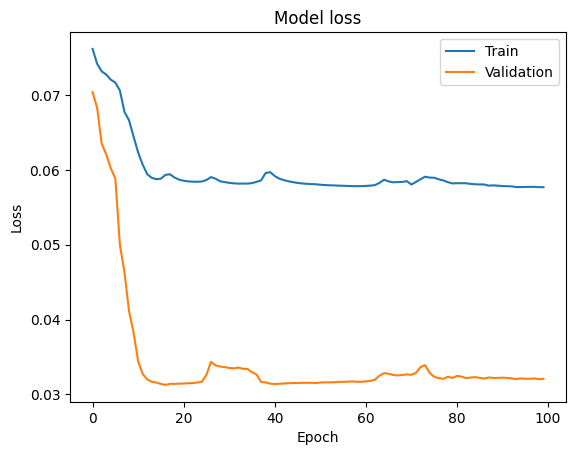

In [34]:
plot_training_history(model_3_history)

In [35]:
model_3_matrix = evaluate(scale(y_test), model_3.predict(scale(x_test)))
model_3_matrix

10/10 [==============================] - 0s 10ms/step


{'mse': array(0.03209526, dtype=float32),
 'mae': array(0.13728134, dtype=float32)}

Batch shape : (8, 256, 256, 3) (8, 256, 256, 3)
1/1 [==============================] - 0s 18ms/step
(256, 256, 3)


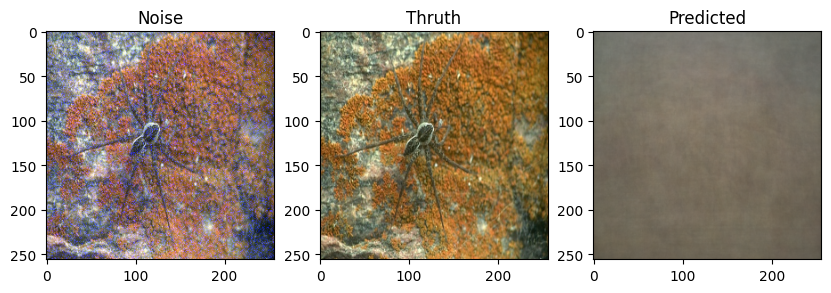

In [36]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[3], sample_y[3], model_3)

## Model 4: convolutional autoencoder (3 conv2, 3 conv2DTranspose)

In [37]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [38]:
model_4 = Autoencoder()
model_4.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [39]:
model_4_history = model_4.fit(train_img_gen,
                epochs=100,
                shuffle=True,
                validation_data=test_img_gen)

Epoch 1/100
151/151 [==============================] - 24s 117ms/step - loss: 0.0399 - val_loss: 0.0110
Epoch 2/100
151/151 [==============================] - 17s 110ms/step - loss: 0.0178 - val_loss: 0.0086
Epoch 3/100
151/151 [==============================] - 17s 110ms/step - loss: 0.0124 - val_loss: 0.0063
Epoch 4/100
151/151 [==============================] - 16s 107ms/step - loss: 0.0104 - val_loss: 0.0061
Epoch 5/100
151/151 [==============================] - 16s 107ms/step - loss: 0.0097 - val_loss: 0.0062
Epoch 6/100
151/151 [==============================] - 16s 107ms/step - loss: 0.0089 - val_loss: 0.0058
Epoch 7/100
151/151 [==============================] - 16s 109ms/step - loss: 0.0086 - val_loss: 0.0056
Epoch 8/100
151/151 [==============================] - 17s 109ms/step - loss: 0.0083 - val_loss: 0.0057
Epoch 9/100
151/151 [==============================] - 16s 109ms/step - loss: 0.0080 - val_loss: 0.0054
Epoch 10/100
151/151 [==============================] - 16s 108m

151/151 [==============================] - 16s 108ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 80/100
151/151 [==============================] - 16s 108ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 81/100
151/151 [==============================] - 16s 108ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 82/100
151/151 [==============================] - 16s 108ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 83/100
151/151 [==============================] - 16s 108ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 84/100
151/151 [==============================] - 16s 108ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 85/100
151/151 [==============================] - 16s 107ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 86/100
151/151 [==============================] - 16s 107ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 87/100
151/151 [==============================] - 16s 107ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 88/100
151/151 [==============================] - 16s 108ms/st

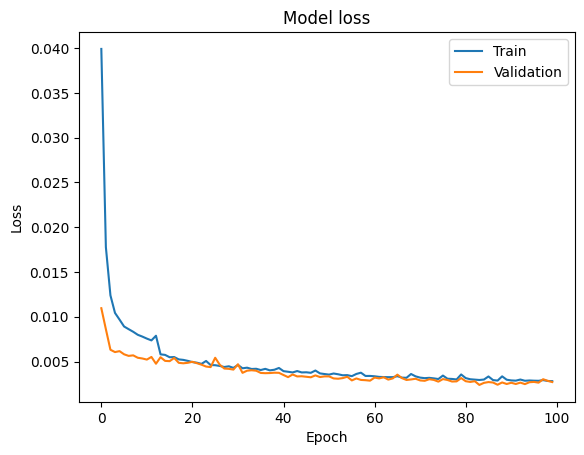

In [40]:
plot_training_history(model_4_history)

In [41]:
model_4_matrix = evaluate(scale(y_test), model_4.predict(scale(x_test)))
model_4_matrix

10/10 [==============================] - 4s 233ms/step


{'mse': array(0.00270914, dtype=float32),
 'mae': array(0.03540301, dtype=float32)}

Batch shape : (8, 256, 256, 3) (8, 256, 256, 3)
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)


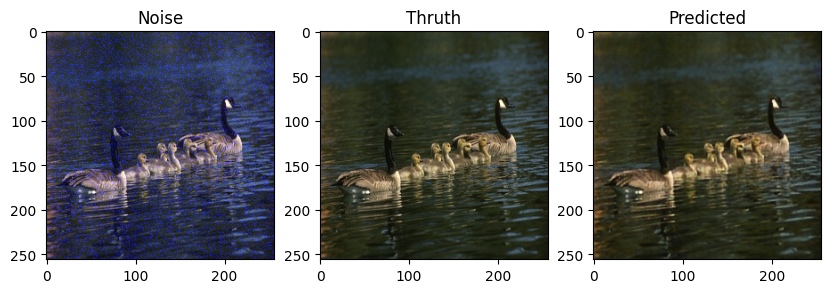

In [42]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_4)

## Model 5: convolutional autoencoder (6 conv2, 6 conv2DTranspose)

In [43]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [44]:
model_5 = Autoencoder()
model_5.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [45]:
model_5_history = model_5.fit(train_img_gen,
                epochs=100,
                verbose=0,
                shuffle=True,
                validation_data=test_img_gen)

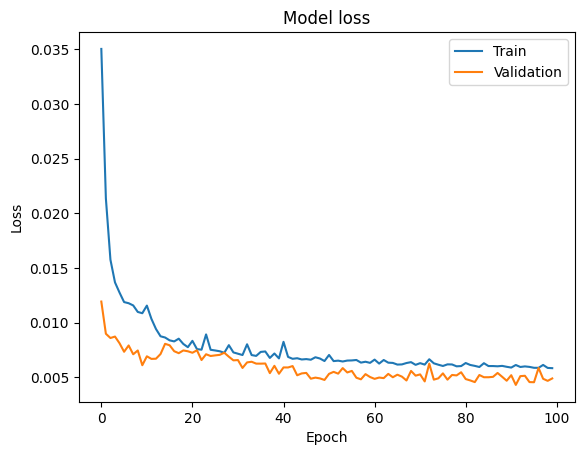

In [46]:
plot_training_history(model_5_history)

In [47]:
model_5_matrix = evaluate(scale(y_test), model_5.predict(scale(x_test)))
model_5_matrix

10/10 [==============================] - 9s 516ms/step


{'mse': array(0.00490841, dtype=float32),
 'mae': array(0.04921354, dtype=float32)}

Batch shape : (8, 256, 256, 3) (8, 256, 256, 3)
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)


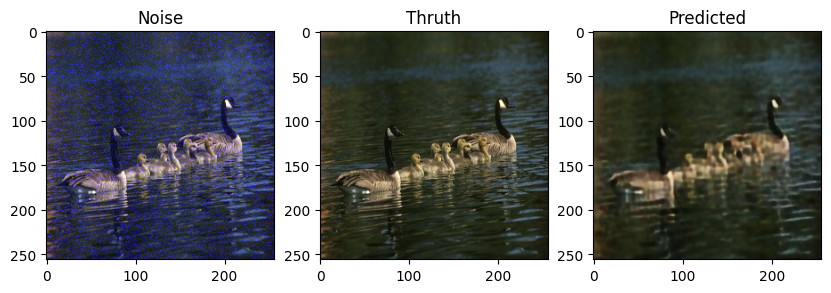

In [48]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_5)

## Model 6: convolutional autoencoder (6 conv2, 6 conv2DTranspose)

In [49]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.5),

            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [50]:
model_6 = Autoencoder()
model_6.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [51]:
model_6_history = model_6.fit(train_img_gen,
                epochs=100,
                verbose=0,
                shuffle=True,
                validation_data=test_img_gen)

2024-01-10 14:01:33.597753: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_3/sequential_6/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


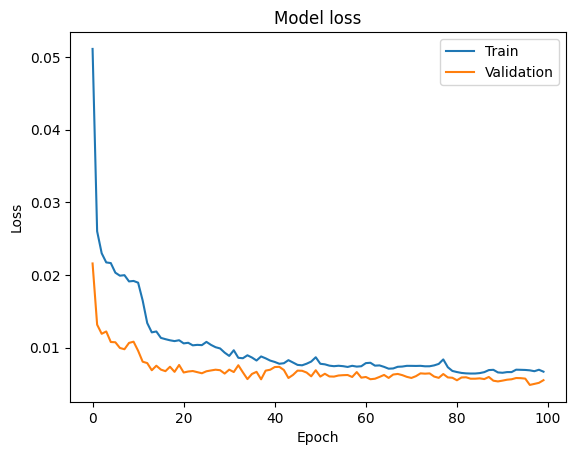

In [52]:
plot_training_history(model_6_history)

In [53]:
model_6_matrix = evaluate(scale(y_test), model_6.predict(scale(x_test)))
model_6_matrix

10/10 [==============================] - 10s 691ms/step


{'mse': array(0.00553793, dtype=float32),
 'mae': array(0.05086606, dtype=float32)}

Batch shape : (8, 256, 256, 3) (8, 256, 256, 3)
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)


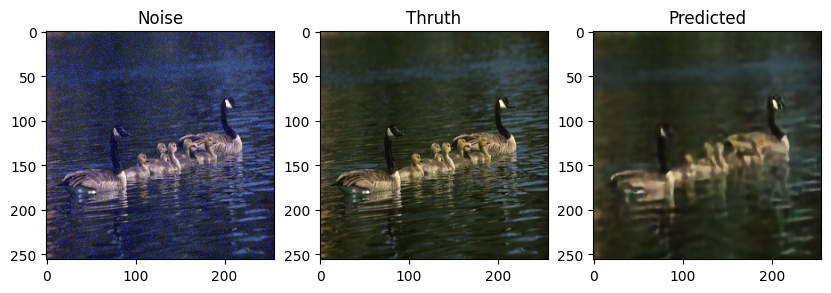

In [54]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_6)

## Model 7: Drop out

In [55]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.5),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.5),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [56]:
model_7 = Autoencoder()
model_7.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [57]:
model_7_history = model_7.fit(train_img_gen,
                epochs=100,
                shuffle=True,
                validation_data=test_img_gen)

Epoch 1/100


2024-01-10 15:42:53.677076: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_4/sequential_8/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


151/151 [==============================] - 68s 425ms/step - loss: 0.0536 - val_loss: 0.0159
Epoch 2/100
151/151 [==============================] - 62s 414ms/step - loss: 0.0270 - val_loss: 0.0131
Epoch 3/100
151/151 [==============================] - 63s 414ms/step - loss: 0.0240 - val_loss: 0.0120
Epoch 4/100
151/151 [==============================] - 63s 414ms/step - loss: 0.0227 - val_loss: 0.0124
Epoch 5/100
151/151 [==============================] - 62s 412ms/step - loss: 0.0220 - val_loss: 0.0120
Epoch 6/100
151/151 [==============================] - 62s 412ms/step - loss: 0.0214 - val_loss: 0.0121
Epoch 7/100
151/151 [==============================] - 62s 412ms/step - loss: 0.0208 - val_loss: 0.0117
Epoch 8/100
151/151 [==============================] - 62s 410ms/step - loss: 0.0204 - val_loss: 0.0117
Epoch 9/100
151/151 [==============================] - 62s 409ms/step - loss: 0.0200 - val_loss: 0.0118
Epoch 10/100
151/151 [==============================] - 62s 408ms/step - los

151/151 [==============================] - 61s 405ms/step - loss: 0.0083 - val_loss: 0.0064
Epoch 80/100
151/151 [==============================] - 61s 405ms/step - loss: 0.0083 - val_loss: 0.0062
Epoch 81/100
151/151 [==============================] - 61s 405ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 82/100
151/151 [==============================] - 61s 406ms/step - loss: 0.0082 - val_loss: 0.0064
Epoch 83/100
151/151 [==============================] - 61s 406ms/step - loss: 0.0081 - val_loss: 0.0065
Epoch 84/100
151/151 [==============================] - 61s 406ms/step - loss: 0.0081 - val_loss: 0.0064
Epoch 85/100
151/151 [==============================] - 61s 406ms/step - loss: 0.0080 - val_loss: 0.0065
Epoch 86/100
151/151 [==============================] - 61s 405ms/step - loss: 0.0079 - val_loss: 0.0061
Epoch 87/100
151/151 [==============================] - 61s 405ms/step - loss: 0.0079 - val_loss: 0.0062
Epoch 88/100
151/151 [==============================] - 61s 405ms/st

In [58]:
model_7.summary()

Model: "autoencoder_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 8, 8, 128)         2072448   
                                                                 
 sequential_9 (Sequential)   (None, 256, 256, 3)       2219907   
                                                                 
Total params: 4292355 (16.37 MB)
Trainable params: 4292355 (16.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


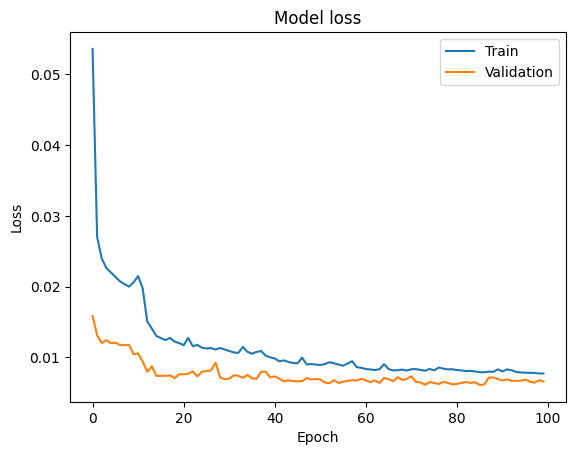

In [59]:
plot_training_history(model_7_history)

In [60]:
model_7_matrix = evaluate(scale(y_test), model_7.predict(scale(x_test)))
model_7_matrix

10/10 [==============================] - 5s 481ms/step


{'mse': array(0.00660476, dtype=float32),
 'mae': array(0.05997895, dtype=float32)}

Batch shape : (8, 256, 256, 3) (8, 256, 256, 3)
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)


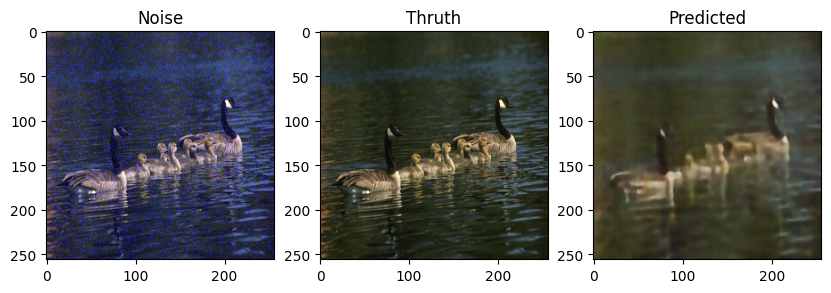

In [61]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_7)

## Model 8: Same as model 7 with diff dropout rate = 0.9

In [62]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.9),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.9),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [63]:
model_8 = Autoencoder()
model_8.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [64]:

model_8_history = model_8.fit(train_img_gen,
                epochs=100,
                shuffle=True,
                validation_data=test_img_gen)

Epoch 1/100


2024-01-10 17:26:24.069340: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_5/sequential_10/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


151/151 [==============================] - 67s 421ms/step - loss: 0.0570 - val_loss: 0.0274
Epoch 2/100
151/151 [==============================] - 62s 408ms/step - loss: 0.0289 - val_loss: 0.0194
Epoch 3/100
151/151 [==============================] - 62s 409ms/step - loss: 0.0244 - val_loss: 0.0179
Epoch 4/100
151/151 [==============================] - 62s 411ms/step - loss: 0.0228 - val_loss: 0.0194
Epoch 5/100
151/151 [==============================] - 62s 408ms/step - loss: 0.0220 - val_loss: 0.0181
Epoch 6/100
151/151 [==============================] - 61s 407ms/step - loss: 0.0209 - val_loss: 0.0193
Epoch 7/100
151/151 [==============================] - 61s 407ms/step - loss: 0.0202 - val_loss: 0.0166
Epoch 8/100
151/151 [==============================] - 61s 407ms/step - loss: 0.0188 - val_loss: 0.0170
Epoch 9/100
151/151 [==============================] - 61s 407ms/step - loss: 0.0149 - val_loss: 0.0180
Epoch 10/100
151/151 [==============================] - 61s 407ms/step - los

151/151 [==============================] - 61s 403ms/step - loss: 0.0082 - val_loss: 0.0216
Epoch 80/100
151/151 [==============================] - 61s 404ms/step - loss: 0.0081 - val_loss: 0.0211
Epoch 81/100
151/151 [==============================] - 61s 404ms/step - loss: 0.0078 - val_loss: 0.0218
Epoch 82/100
151/151 [==============================] - 61s 405ms/step - loss: 0.0077 - val_loss: 0.0220
Epoch 83/100
151/151 [==============================] - 61s 405ms/step - loss: 0.0079 - val_loss: 0.0221
Epoch 84/100
151/151 [==============================] - 61s 404ms/step - loss: 0.0081 - val_loss: 0.0208
Epoch 85/100
151/151 [==============================] - 61s 404ms/step - loss: 0.0080 - val_loss: 0.0221
Epoch 86/100
151/151 [==============================] - 61s 403ms/step - loss: 0.0081 - val_loss: 0.0214
Epoch 87/100
151/151 [==============================] - 61s 404ms/step - loss: 0.0079 - val_loss: 0.0220
Epoch 88/100
151/151 [==============================] - 61s 404ms/st

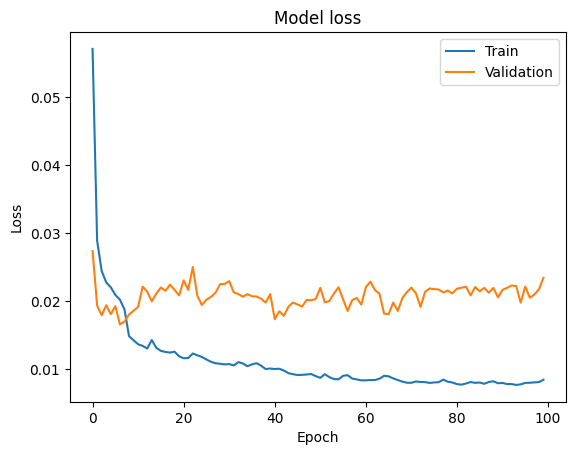

In [65]:
plot_training_history(model_8_history)

In [66]:
model_8_matrix = evaluate(scale(y_test), model_8.predict(scale(x_test)))
model_8_matrix

10/10 [==============================] - 5s 482ms/step


{'mse': array(0.02342944, dtype=float32),
 'mae': array(0.12772967, dtype=float32)}

Batch shape : (8, 256, 256, 3) (8, 256, 256, 3)
1/1 [==============================] - 0s 21ms/step
(256, 256, 3)


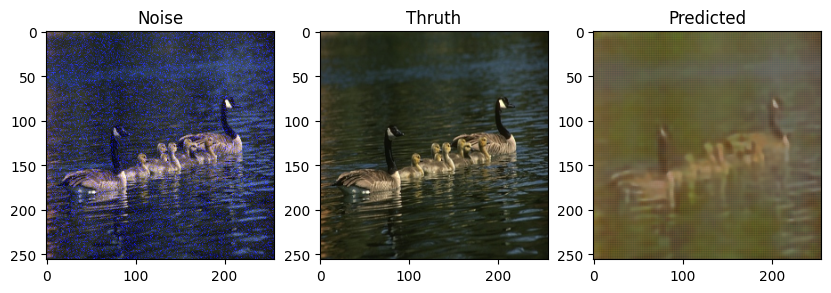

In [67]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_8)

## Model 9: Same as model 7 with diff dropout rate = 0.2

In [68]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [69]:
model_9 = Autoencoder()
model_9.compile(optimizer='adam', loss=losses.MeanSquaredError())
model_9_history = model_9.fit(train_img_gen,
                epochs=100,
                shuffle=True,
                validation_data=test_img_gen)

Epoch 1/100


2024-01-10 19:10:04.783420: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_6/sequential_12/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


151/151 [==============================] - 67s 423ms/step - loss: 0.0553 - val_loss: 0.0171
Epoch 2/100
151/151 [==============================] - 62s 412ms/step - loss: 0.0260 - val_loss: 0.0146
Epoch 3/100
151/151 [==============================] - 62s 412ms/step - loss: 0.0231 - val_loss: 0.0116
Epoch 4/100
151/151 [==============================] - 62s 413ms/step - loss: 0.0217 - val_loss: 0.0116
Epoch 5/100
151/151 [==============================] - 62s 410ms/step - loss: 0.0212 - val_loss: 0.0111
Epoch 6/100
151/151 [==============================] - 62s 411ms/step - loss: 0.0205 - val_loss: 0.0104
Epoch 7/100
151/151 [==============================] - 62s 409ms/step - loss: 0.0197 - val_loss: 0.0118
Epoch 8/100
151/151 [==============================] - 62s 408ms/step - loss: 0.0194 - val_loss: 0.0102
Epoch 9/100
151/151 [==============================] - 62s 410ms/step - loss: 0.0179 - val_loss: 0.0101
Epoch 10/100
151/151 [==============================] - 62s 410ms/step - los

151/151 [==============================] - 61s 407ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 80/100
151/151 [==============================] - 61s 407ms/step - loss: 0.0072 - val_loss: 0.0056
Epoch 81/100
151/151 [==============================] - 61s 407ms/step - loss: 0.0075 - val_loss: 0.0055
Epoch 82/100
151/151 [==============================] - 61s 406ms/step - loss: 0.0072 - val_loss: 0.0061
Epoch 83/100
151/151 [==============================] - 61s 407ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 84/100
151/151 [==============================] - 61s 407ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 85/100
151/151 [==============================] - 61s 406ms/step - loss: 0.0068 - val_loss: 0.0054
Epoch 86/100
151/151 [==============================] - 61s 407ms/step - loss: 0.0071 - val_loss: 0.0064
Epoch 87/100
151/151 [==============================] - 61s 407ms/step - loss: 0.0073 - val_loss: 0.0059
Epoch 88/100
151/151 [==============================] - 61s 407ms/st

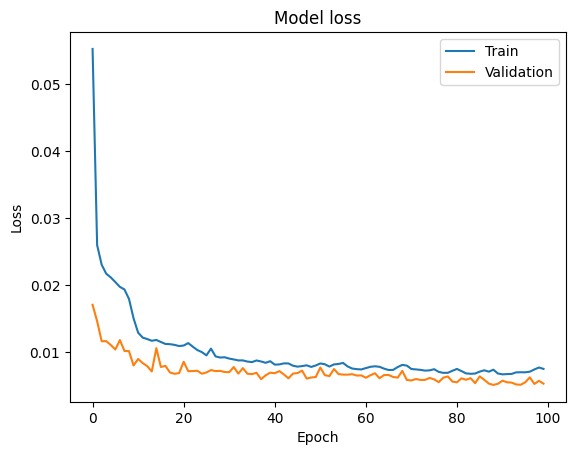

In [70]:
plot_training_history(model_9_history)

Batch shape : (8, 256, 256, 3) (8, 256, 256, 3)
1/1 [==============================] - 0s 161ms/step
(256, 256, 3)


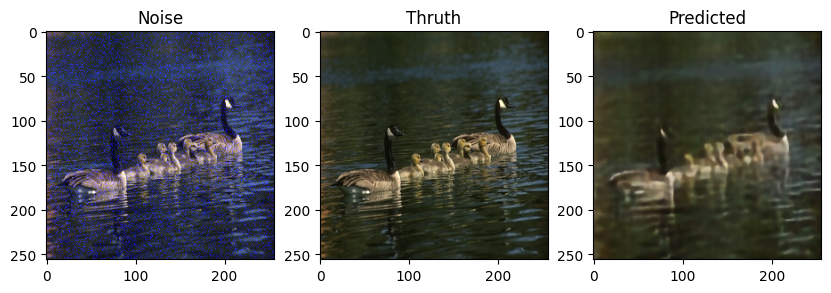

In [71]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_9)

In [72]:
model_9_matrix = evaluate(scale(y_test), model_9.predict(scale(x_test)))
model_9_matrix

10/10 [==============================] - 4s 481ms/step


{'mse': array(0.00529653, dtype=float32),
 'mae': array(0.05128082, dtype=float32)}

## Model 10 : dropout every layer with rate=0.2

In [73]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(self.shape[0], (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [74]:
model_10 = Autoencoder()
model_10.compile(optimizer='adam', loss=losses.MeanSquaredError())
model_10_history = model_10.fit(train_img_gen,
                epochs=100,
                shuffle=True,
                validation_data=test_img_gen)

Epoch 1/100


2024-01-10 20:54:39.221580: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_7/sequential_14/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


151/151 [==============================] - 71s 447ms/step - loss: 0.0533 - val_loss: 0.0163
Epoch 2/100
151/151 [==============================] - 66s 438ms/step - loss: 0.0280 - val_loss: 0.0152
Epoch 3/100
151/151 [==============================] - 66s 436ms/step - loss: 0.0251 - val_loss: 0.0144
Epoch 4/100
151/151 [==============================] - 66s 437ms/step - loss: 0.0239 - val_loss: 0.0120
Epoch 5/100
151/151 [==============================] - 66s 436ms/step - loss: 0.0232 - val_loss: 0.0117
Epoch 6/100
151/151 [==============================] - 66s 435ms/step - loss: 0.0226 - val_loss: 0.0130
Epoch 7/100
151/151 [==============================] - 66s 435ms/step - loss: 0.0219 - val_loss: 0.0110
Epoch 8/100
151/151 [==============================] - 65s 434ms/step - loss: 0.0225 - val_loss: 0.0116
Epoch 9/100
151/151 [==============================] - 65s 433ms/step - loss: 0.0208 - val_loss: 0.0112
Epoch 10/100
151/151 [==============================] - 65s 433ms/step - los

151/151 [==============================] - 65s 432ms/step - loss: 0.0111 - val_loss: 0.0087
Epoch 80/100
151/151 [==============================] - 65s 432ms/step - loss: 0.0112 - val_loss: 0.0080
Epoch 81/100
151/151 [==============================] - 65s 433ms/step - loss: 0.0108 - val_loss: 0.0084
Epoch 82/100
151/151 [==============================] - 65s 433ms/step - loss: 0.0105 - val_loss: 0.0086
Epoch 83/100
151/151 [==============================] - 65s 433ms/step - loss: 0.0105 - val_loss: 0.0094
Epoch 84/100
151/151 [==============================] - 65s 433ms/step - loss: 0.0104 - val_loss: 0.0089
Epoch 85/100
151/151 [==============================] - 65s 433ms/step - loss: 0.0104 - val_loss: 0.0096
Epoch 86/100
151/151 [==============================] - 65s 433ms/step - loss: 0.0103 - val_loss: 0.0087
Epoch 87/100
151/151 [==============================] - 65s 433ms/step - loss: 0.0104 - val_loss: 0.0110
Epoch 88/100
151/151 [==============================] - 65s 433ms/st

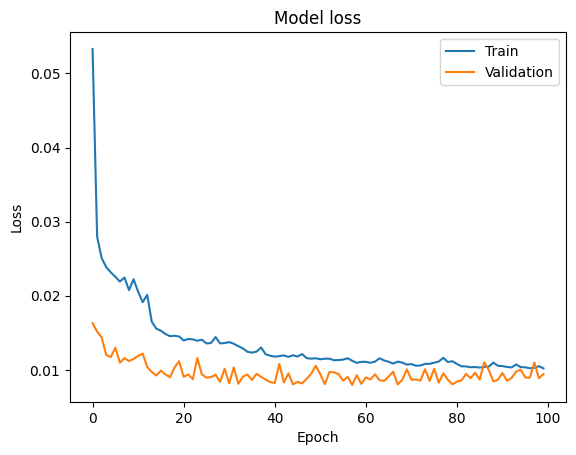

In [75]:
plot_training_history(model_10_history)

Batch shape : (8, 256, 256, 3) (8, 256, 256, 3)
1/1 [==============================] - 0s 164ms/step
(256, 256, 3)


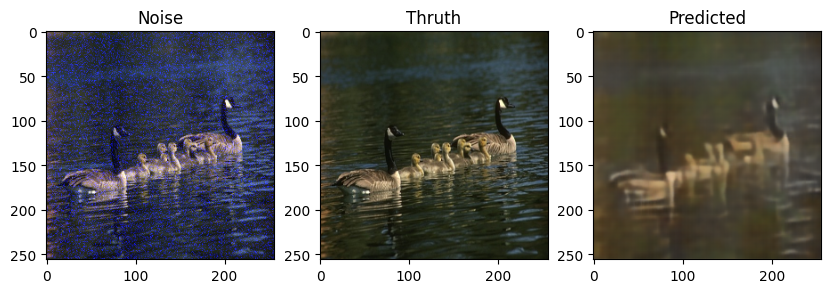

In [76]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_10)

In [77]:
model_10_matrix = evaluate(scale(y_test), model_10.predict(scale(x_test)))
model_10_matrix

10/10 [==============================] - 4s 483ms/step


{'mse': array(0.0094297, dtype=float32), 'mae': array(0.076664, dtype=float32)}

## Model 11 : same as Model 4 with drop out rate =0.2

In [78]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dropout(0.2),
            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
model_11 = Autoencoder()
model_11.compile(optimizer='adam', loss=losses.MeanSquaredError())

model_11_history = model_11.fit(train_img_gen,
                epochs=100,
                shuffle=True,
                validation_data=test_img_gen)

Epoch 1/100


2024-01-10 22:45:05.447352: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_8/sequential_16/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


151/151 [==============================] - 25s 151ms/step - loss: 0.0333 - val_loss: 0.0114
Epoch 2/100
151/151 [==============================] - 22s 146ms/step - loss: 0.0211 - val_loss: 0.0103
Epoch 3/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0196 - val_loss: 0.0098
Epoch 4/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0190 - val_loss: 0.0094
Epoch 5/100
151/151 [==============================] - 22s 144ms/step - loss: 0.0184 - val_loss: 0.0089
Epoch 6/100
151/151 [==============================] - 22s 145ms/step - loss: 0.0142 - val_loss: 0.0082
Epoch 7/100
151/151 [==============================] - 22s 144ms/step - loss: 0.0120 - val_loss: 0.0071
Epoch 8/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0115 - val_loss: 0.0070
Epoch 9/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0112 - val_loss: 0.0067
Epoch 10/100
151/151 [==============================] - 22s 144ms/step - los

151/151 [==============================] - 22s 143ms/step - loss: 0.0068 - val_loss: 0.0082
Epoch 80/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0067 - val_loss: 0.0079
Epoch 81/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0068 - val_loss: 0.0083
Epoch 82/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0068 - val_loss: 0.0085
Epoch 83/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0068 - val_loss: 0.0076
Epoch 84/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0067 - val_loss: 0.0075
Epoch 85/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0067 - val_loss: 0.0072
Epoch 86/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0067 - val_loss: 0.0074
Epoch 87/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0066 - val_loss: 0.0080
Epoch 88/100
151/151 [==============================] - 22s 143ms/st

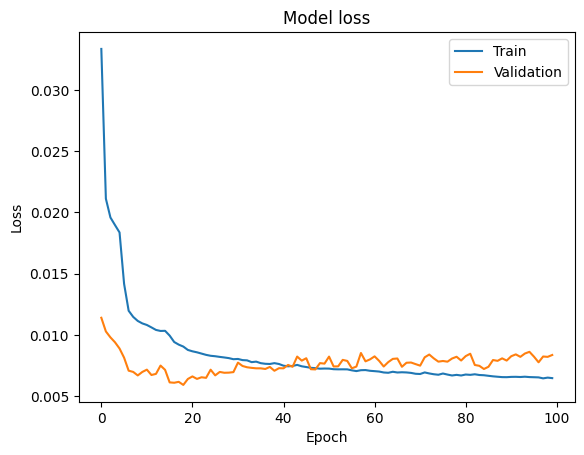

In [79]:
plot_training_history(model_11_history)

Batch shape : (8, 256, 256, 3) (8, 256, 256, 3)
1/1 [==============================] - 0s 116ms/step
(256, 256, 3)


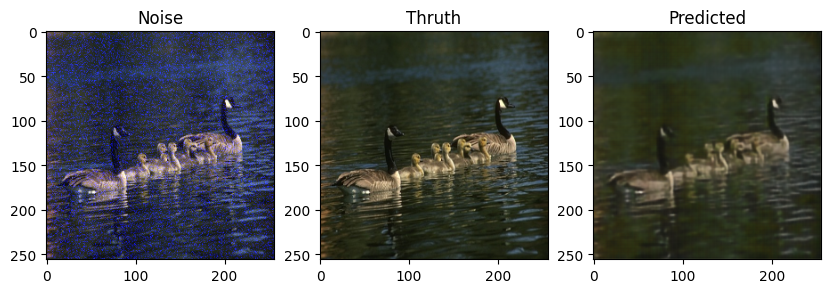

In [80]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_11)

In [81]:
model_11_matrix = evaluate(scale(y_test), model_11.predict(scale(x_test)))
model_11_matrix

10/10 [==============================] - 1s 146ms/step


{'mse': array(0.00837499, dtype=float32),
 'mae': array(0.06875464, dtype=float32)}

## Model 12: Same as Model 11 but with one more layer (latent_dim = 16)

In [82]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dropout(0.2),
            layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
model_12 = Autoencoder()
model_12.compile(optimizer='adam', loss=losses.MeanSquaredError())

model_12_history = model_12.fit(train_img_gen,
                epochs=100,
                shuffle=True,
                validation_data=test_img_gen)

Epoch 1/100


2024-01-10 23:22:41.979850: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_9/sequential_18/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


151/151 [==============================] - 26s 152ms/step - loss: 0.0520 - val_loss: 0.0272
Epoch 2/100
151/151 [==============================] - 22s 147ms/step - loss: 0.0310 - val_loss: 0.0186
Epoch 3/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0280 - val_loss: 0.0196
Epoch 4/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0269 - val_loss: 0.0212
Epoch 5/100
151/151 [==============================] - 22s 145ms/step - loss: 0.0263 - val_loss: 0.0186
Epoch 6/100
151/151 [==============================] - 22s 145ms/step - loss: 0.0257 - val_loss: 0.0198
Epoch 7/100
151/151 [==============================] - 22s 144ms/step - loss: 0.0253 - val_loss: 0.0189
Epoch 8/100
151/151 [==============================] - 22s 144ms/step - loss: 0.0249 - val_loss: 0.0201
Epoch 9/100
151/151 [==============================] - 22s 144ms/step - loss: 0.0246 - val_loss: 0.0197
Epoch 10/100
151/151 [==============================] - 22s 144ms/step - los

151/151 [==============================] - 22s 143ms/step - loss: 0.0146 - val_loss: 0.0202
Epoch 80/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0145 - val_loss: 0.0214
Epoch 81/100
151/151 [==============================] - 22s 144ms/step - loss: 0.0144 - val_loss: 0.0212
Epoch 82/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0144 - val_loss: 0.0222
Epoch 83/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0144 - val_loss: 0.0223
Epoch 84/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0144 - val_loss: 0.0212
Epoch 85/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0145 - val_loss: 0.0202
Epoch 86/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0143 - val_loss: 0.0216
Epoch 87/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0144 - val_loss: 0.0189
Epoch 88/100
151/151 [==============================] - 22s 143ms/st

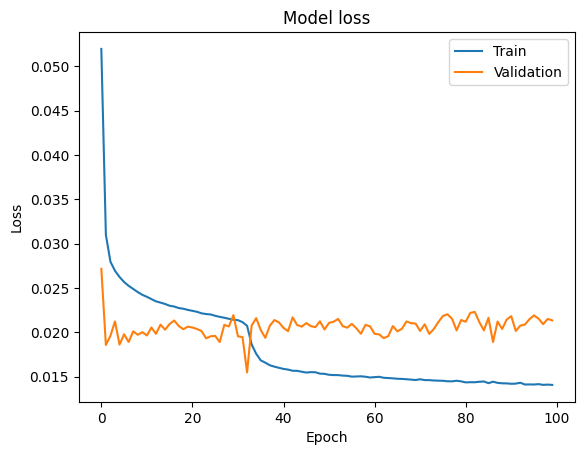

In [83]:
plot_training_history(model_12_history)

Batch shape : (8, 256, 256, 3) (8, 256, 256, 3)
1/1 [==============================] - 0s 148ms/step
(256, 256, 3)


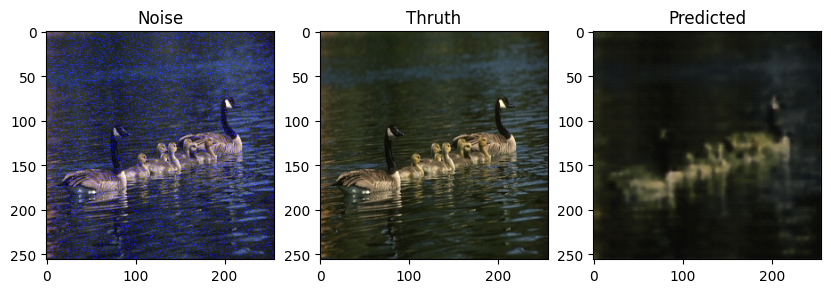

In [84]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_12)

In [85]:
model_12_matrix = evaluate(scale(y_test), model_12.predict(scale(x_test)))
model_12_matrix

10/10 [==============================] - 1s 151ms/step


{'mse': array(0.02135534, dtype=float32),
 'mae': array(0.12085433, dtype=float32)}

## Model 13: Same as 11 but with latent dim 64

In [86]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
model_13 = Autoencoder()
model_13.compile(optimizer='adam', loss=losses.MeanSquaredError())

model_13_history = model_13.fit(train_img_gen,
                epochs=100,
                shuffle=True,
                validation_data=test_img_gen)

Epoch 1/100


2024-01-11 00:00:54.463771: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_10/sequential_20/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


151/151 [==============================] - 25s 150ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/100
151/151 [==============================] - 22s 144ms/step - loss: 0.0083 - val_loss: 0.0040
Epoch 3/100
151/151 [==============================] - 21s 141ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 4/100
151/151 [==============================] - 21s 141ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 5/100
151/151 [==============================] - 21s 142ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 6/100
151/151 [==============================] - 22s 143ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 7/100
151/151 [==============================] - 21s 142ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 8/100
151/151 [==============================] - 21s 142ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 9/100
151/151 [==============================] - 21s 142ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 10/100
151/151 [==============================] - 21s 142ms/step - los

In [ ]:
plot_training_history(model_13_history)

In [ ]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_13)

In [ ]:
model_13_matrix = evaluate(scale(y_test), model_13.predict(scale(x_test)))
model_13_matrix

## Model 14: Same as model 11 but adding more large nuerons layers

In [ ]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
model_14 = Autoencoder()
model_14.compile(optimizer='adam', loss=losses.MeanSquaredError())

model_14_history = model_14.fit(train_img_gen,
                epochs=100,
                shuffle=True,
                validation_data=test_img_gen)

In [ ]:
plot_training_history(model_14_history)

In [ ]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_14)

In [ ]:
model_14_matrix = evaluate(scale(y_test), model_14.predict(scale(x_test)))
model_14_matrix

## Model 15: same as model 13 without drop out

In [ ]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
model_15 = Autoencoder()
model_15.compile(optimizer='adam', loss=losses.MeanSquaredError())

model_15_history = model_15.fit(train_img_gen,
                epochs=100,
                shuffle=True,
                validation_data=test_img_gen)

In [ ]:
plot_training_history(model_15_history)

In [ ]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_15)

In [ ]:
model_15_matrix = evaluate(scale(y_test), model_15.predict(scale(x_test)))
model_15_matrix

## Model 16: One layer latent dim = 128

In [ ]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
model_16 = Autoencoder()
model_16.compile(optimizer='adam', loss=losses.MeanSquaredError())

model_16_history = model_16.fit(train_img_gen,
                epochs=100,
                shuffle=True,
                validation_data=test_img_gen)

In [ ]:
plot_training_history(model_16_history)

In [ ]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_16)

In [ ]:
model_16_matrix = evaluate(scale(y_test), model_16.predict(scale(x_test)))
model_16_matrix

## Model 17: Same as Model 16 with dropout

In [ ]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
model_17 = Autoencoder()
model_17.compile(optimizer='adam', loss=losses.MeanSquaredError())

model_17_history = model_17.fit(train_img_gen,
                epochs=100,
                shuffle=True,
                validation_data=test_img_gen)

In [ ]:
plot_training_history(model_17_history)

In [ ]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_17)

In [ ]:
model_17_matrix = evaluate(scale(y_test), model_17.predict(scale(x_test)))
model_17_matrix

## Model 18: same as model 16 with diff kernel size

In [ ]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(128, (5, 5), activation='relu', padding='same', strides=2),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(128, (5, 5), activation='relu', padding='same', strides=2),
            layers.Conv2D(3, kernel_size=(5, 5), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
model_18 = Autoencoder()
model_18.compile(optimizer='adam', loss=losses.MeanSquaredError())

model_18_history = model_18.fit(train_img_gen,
                epochs=100,
                shuffle=True,
                validation_data=test_img_gen)

In [ ]:
plot_training_history(model_18_history)

In [ ]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_18)

In [ ]:
model_18_matrix = evaluate(scale(y_test), model_18.predict(scale(x_test)))
model_18_matrix

## Model 19: Same as 18 but 7 kernel size

In [ ]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(128, (7, 7), activation='relu', padding='same', strides=2),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(128, (7, 7), activation='relu', padding='same', strides=2),
            layers.Conv2D(3, kernel_size=(7, 7), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
model_19 = Autoencoder()
model_19.compile(optimizer='adam', loss=losses.MeanSquaredError())

model_19_history = model_19.fit(train_img_gen,
                epochs=100,
                shuffle=True,
                validation_data=test_img_gen)

In [ ]:
plot_training_history(model_19_history)

In [ ]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_19)

In [ ]:
model_19_matrix = evaluate(scale(y_test), model_19.predict(scale(x_test)))
model_19_matrix

## Model 20: Same as 16 with stride 1

In [ ]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=1),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=1),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
model_20 = Autoencoder()
model_20.compile(optimizer='adam', loss=losses.MeanSquaredError())

model_20_history = model_20.fit(train_img_gen,
                epochs=100,
                shuffle=True,
                validation_data=test_img_gen)

In [ ]:
plot_training_history(model_20_history)

In [ ]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_20)

In [ ]:
model_20_matrix = evaluate(scale(y_test), model_20.predict(scale(x_test)))
model_20_matrix

## Model 21: same as 20 with kernel size = 2

In [ ]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(128, (2, 2), activation='relu', padding='same', strides=1),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(128, (2, 2), activation='relu', padding='same', strides=1),
            layers.Conv2D(3, kernel_size=(2, 2), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
model_21 = Autoencoder()
model_21.compile(optimizer='adam', loss=losses.MeanSquaredError())

model_21_history = model_21.fit(train_img_gen,
                epochs=100,
                shuffle=True,
                validation_data=test_img_gen)

In [ ]:
plot_training_history(model_21_history)

In [ ]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_21)

In [ ]:
model_21_matrix = evaluate(scale(y_test), model_21.predict(scale(x_test)))
model_21_matrix

## Model 22: same as Model 21 with kernel 1

In [ ]:
class Autoencoder(Model):
    def __init__(self, shape=IMAGE_SHAPE):
        super(Autoencoder, self).__init__()
        self.shape =  shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=self.shape),
            layers.Conv2D(128, (1, 1), activation='relu', padding='same', strides=1),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(128, (1, 1), activation='relu', padding='same', strides=1),
            layers.Conv2D(3, kernel_size=(1, 1), activation='sigmoid', padding='same') # 3 channels
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
model_22 = Autoencoder()
model_22.compile(optimizer='adam', loss=losses.MeanSquaredError())

model_22_history = model_22.fit(train_img_gen,
                epochs=100,
                shuffle=True,
                validation_data=test_img_gen)

In [ ]:
plot_training_history(model_22_history)

In [ ]:
sample_x, sample_y = return_sample_from_batch(test_img_gen)
print("Batch shape :",sample_x.shape, sample_y.shape)
make_prediction_plot(sample_x[0], sample_y[0], model_22)

In [ ]:
model_22_matrix = evaluate(scale(y_test), model_22.predict(scale(x_test)))
model_22_matrix

# Comparing the Models

In [ ]:
metrics_models = pd.DataFrame([model_1_matrix, model_2_matrix,model_3_matrix,model_4_matrix,
                               model_5_matrix, model_6_matrix, model_7_matrix, model_8_matrix,
                               model_9_matrix, model_10_matrix,model_11_matrix,
                               model_12_matrix, model_13_matrix, model_14_matrix, model_15_matrix,
                               model_16_matrix, model_17_matrix, model_18_matrix, model_19_matrix,
                               model_20_matrix, model_21_matrix, model_22_matrix])
metrics_models.index = [f'model_{i}' for i in range(1, 23)]
metrics_models

In [ ]:
metrics_models['mse'] = metrics_models['mse'].astype('float32')
metrics_models['mae'] = metrics_models['mae'].astype('float32')

In [ ]:
metrics_models.head()

In [ ]:
metrics_models['mse'].sort_values().plot(kind='bar', figsize=(12, 6))

plt.title('Mean Squared Error (MSE) for Different Models')

plt.xlabel('Model')
plt.ylabel('MSE')

In [ ]:
metrics_models['mae'].sort_values().plot(kind='bar', figsize=(12, 6))

plt.title('Mean Absolute Error (MSE) for Different Models')

plt.xlabel('Model')
plt.ylabel('MAE')

# TODOs:
- [ ] Add more images
- [ ] Train Longer